# PRIMMDebug Log Data Analysis Notebook
This notebook displays all of the analysis of the log data that took place in the PRIMMDebug initial research paper.

The log data was collected from five schools between December 2024-Month 2025. It is divided into the following sections:
1. **Summary statistics:** An overview of the scale of the data and a breakdown of the participants.
2. **Establishing variables:** A closer look at some variables of interest, including time on task and success on the PRIMMDebug challenges.
3. **Cluster analysis:** Documentation of the clustering process.

All you need to do is run the notebooks in order and the statistics that appear in the paper will be displayed. If there are any issues, please report them in the [Issues section of the GitHub repository](https://github.com/LaurieGale10/primmdebug-log-data-analysis/issues).

Before we run anything else, let's first import all of the necessary libraries and data.

In [1]:
from classes.stage_log import StageLog
from classes.exercise_log import ExerciseLog
from classes.student_id import StudentId
from classes.exercise_classes.exercise import Exercise
from classes.processors.exercise_log_processor import ExerciseLogProcessor
from classes.processors.stage_log_processor import StageLogProcessor

from loading_services.fetch_logs_from_file import fetch_data_from_json
from loading_services.parse_logs import *

from testing_service.docker_interface import DockerInterface
from testing_service.test_report import TestReport

from constants import *
from notebook_utils import *

import plotly.express as px
import plotly.graph_objects as go
from collections import Counter
from statistics import median
from math import isnan
import datetime
from collections import defaultdict

#Libraries for clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from kmedoids import *
from pandas import DataFrame, read_csv, cut
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.stats import pointbiserialr

"""
#Some clustering-related functions don't have good Python implementations, for which R libraries are used instead.
import os
os.environ["R_HOME"] = "C:\\Program Files\\R\\R-4.5.0"
os.environ["R_LIBS_USER"] = "C:\\Program Files\\R\\R-4.5.0\\library"
import rpy2
from rpy2.robjects import default_converter, rinterface, pandas2ri
from rpy2.robjects.packages import importr, isinstalled
from rpy2.robjects.vectors import StrVector

utils = importr('utils')
utils.chooseCRANmirror(ind=1)
packnames = ('clustertend', 'WeightedCluster', 'factoextra')
names_to_install = [x for x in packnames if not isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))
"""

print("Loading logs")
EXERCISES: list[Exercise] = parse_exercises(fetch_data_from_json("data/exercises"))
STAGE_LOGS: list[StageLog] = parse_stage_logs(fetch_data_from_json("data/cleaned_stage_logs"))
EXERCISE_LOGS: list[ExerciseLog] = parse_exercise_logs(STAGE_LOGS, fetch_data_from_json("data/cleaned_exercise_logs"))
STUDENT_IDS: list[StudentId] = parse_student_ids(fetch_data_from_json("data/student_ids"), EXERCISE_LOGS)

for exercise_log in EXERCISE_LOGS:
    exercise_log = ExerciseLogProcessor.add_correctness_to_test_stages(exercise_log)

#Initiate Docker container
run_tests: bool = False
if run_tests:
    print("Adding test harness data")
    docker_interface: DockerInterface = DockerInterface.get_instance()
    docker_interface.create_docker_container()
    test_reports: list[TestReport] = []

    for exercise_log in EXERCISE_LOGS:
        exercise_test_report: TestReport = ExerciseLogProcessor.test_final_program(exercise_log, docker_interface)
        if exercise_test_report is not None:
            test_reports.append(exercise_test_report)
            exercise_log._test_report = exercise_test_report

    docker_interface.close_docker_container()

print("Adding session data")
EXERCISE_LOGS_PER_SESSION: dict[int, list[ExerciseLog]] = {}
for exercise_log in EXERCISE_LOGS:
    session_number: int = exercise_log.session
    EXERCISE_LOGS_PER_SESSION[session_number] = EXERCISE_LOGS_PER_SESSION.get(session_number, []) + [exercise_log]

Loading logs
Adding session data


## Summary Statistics

### Log Data Summary
This data displays the following summary statistics to give information into the scale of the data we collected. We report below on:
- Number of exercises
  - Per student
  - Per session
- Number of PRIMMDebug stages
  - Per challenge attempt

In [3]:
print(f"Number of attempted PRIMMDebug challenges: {len(EXERCISE_LOGS)}")
print(f"Number of completed PRIMMDebug stages: {len(STAGE_LOGS)}")
total_time: float = sum([ExerciseLogProcessor.get_time_on_exercise(exercise_log) for exercise_log in EXERCISE_LOGS])
print(f"Total time on PRIMMDebug challenges: {datetime.timedelta(seconds=total_time)}\n")

print(f"Number of students who consented to taking part in the study: {11+16+25+26+16}")
print(f"Total number of students who attempted at least one PRIMMDebug challenge: {len(STUDENT_IDS)}\n") #TODO: Clean number of student IDs to those who only attempted one exercise

#Number of attempts at each PRIMMDebug challenge
challenge_attempts: dict[str, int] = {}
for exercise_log in EXERCISE_LOGS:
    challenge_attempts[exercise_log.exercise_name] = challenge_attempts.get(exercise_log.exercise_name, 0) + 1
challenge_attempts = dict(sorted(challenge_attempts.items(), key=lambda item: item[1], reverse=True)) #Sort by frequency
px.bar(
    x = challenge_attempts.keys(),
    y = challenge_attempts.values(),
    labels = {"x": "Challenge Name", "y": "Frequency"},
    title=f"Number of attempts for each PRIMMDebug challenge (n={len(EXERCISE_LOGS)})"
).show()

#Number of challenges attempted by each student
challenges_per_student: dict[str, int] = {}
for exercise in EXERCISE_LOGS:
    student_id: str = exercise.student_id
    challenges_per_student[student_id] = challenges_per_student.get(student_id, 0) + 1
px.histogram(
    challenges_per_student.values(),
    marginal="box",
    labels={"value": "Number of challenges", "count": "Frequency"},
    title=f"Number of attempted PRIMMDebug challenges, broken down by student (n={len(challenges_per_student)})"
).show()

# Number of stages per PRIMMDebug challenge attempt
stages_per_challenge_attempt: list[int] = [len(exercise.stage_logs) for exercise in EXERCISE_LOGS]
px.histogram(
    stages_per_challenge_attempt,
    marginal="box",
    labels={"value": "Number of stages", "count": "Frequency"},
    title=f"Number of stages per PRIMMDebug challenge attempt (n={len(stages_per_challenge_attempt)})"
).show()

# Number of challenge attempts per session
attempts_per_session: dict[int, int] = {}
for session, logs in EXERCISE_LOGS_PER_SESSION.items():
    attempts_per_session[session] = len(logs)
px.bar(
    x=attempts_per_session.keys(),
    y=attempts_per_session.values(),
    labels={"x": "Session", "y": "Frequency"},
    title=f"Number of PRIMMDebug challenges in each session (n={sum(attempts_per_session.values())})"
).show()

# Final stage of PRIMMDebug challenge attempts
challenge_end_stages: dict[str, int] = dict(Counter([ExerciseLogProcessor.get_last_stage(exercise_log).stage_name.name for exercise_log in EXERCISE_LOGS]))
challenge_end_stages = {stage.name: challenge_end_stages.get(stage.name, 0) for stage in DebuggingStage if stage.name not in ["completed_test", "exit"]}
px.bar(
    x=list(challenge_end_stages.keys()),
    y=list(challenge_end_stages.values()),
    labels={"x": "PRIMMDebug stage", "y": "Frequency"},
    title=f"Final stage of PRIMMDebug challenge attempts (n={len(EXERCISE_LOGS)})"
).show()

Number of attempted PRIMMDebug challenges: 377
Number of completed PRIMMDebug stages: 4273
Total time on PRIMMDebug challenges: 2 days, 1:48:42.253000

Number of students who consented to taking part in the study: 94
Total number of students who attempted at least one PRIMMDebug challenge: 69



### Student Demographics

Number of students:
- By gender
- By year group
- By school


In [6]:
print(f"Number of participating students: {len(STUDENT_IDS)}") #TODO: Implement as csv file to save
school_split_fig = px.bar(x = get_school_split().keys(), y = get_school_split().values(), labels={"x": "School", "y": "Frequency"})
school_split_fig.show()

Number of participating students: 69


## Establishing Variables
Now we move onto introducing the variables that underpin our log data analysis. These are:
- Time taken
  - Per challenge attempt
    - Per session
  - Per stage log
  - Per PRIMMDebug stage
    - Per session
- Correctness
- Engagement

### Time Taken

First, we present the distribution of times taken for each PRIMMDebug challenge and stage.

In [2]:
import numpy as np

#Time taken per PRIMMDebug challenge attempt
time_per_challenge_attempt: list[float] = [ExerciseLogProcessor.get_time_on_exercise(exercise) for exercise in EXERCISE_LOGS if hasattr(exercise,"end_time")]
import scipy.stats as stats

skewness = stats.skew(time_per_challenge_attempt, nan_policy='omit')
kurtosis = stats.kurtosis(time_per_challenge_attempt, nan_policy='omit')
sd = np.nanstd(time_per_challenge_attempt)

px.histogram(
    time_per_challenge_attempt, marginal="box",
    labels={"value": "Time taken (seconds)", "count": "Count"},
    title=f"Time taken per PRIMMDebug challenge (skewness={skewness:.2f}, kurtosis={kurtosis:.2f}, std={sd:.2f})"
).show()

#Time series for time per PRIMMDebug challenge attempt
median_time_per_challenge_per_session: dict[int, float] = {}
for session_id, logs in EXERCISE_LOGS_PER_SESSION.items():
    median_time_per_challenge = median([ExerciseLogProcessor.get_time_on_exercise(log) for log in logs if hasattr(log, "end_time")])
    median_time_per_challenge_per_session[session_id] = median_time_per_challenge

median_time_per_challenge_per_session = dict(sorted(median_time_per_challenge_per_session.items()))
px.line(
    x=median_time_per_challenge_per_session.keys(),
    y=median_time_per_challenge_per_session.values(),
    labels={"x": "Session", "y": "Median time (seconds)"},
    title="Median time spent on each PRIMMDebug challenge per session"
).show()

#Time taken per stage log
time_per_stage: list[float] = [StageLogProcessor.get_time_on_stage(stage) for stage in STAGE_LOGS if StageLogProcessor.get_time_on_stage(stage) is not None]
skewness_stage = stats.skew(time_per_stage, nan_policy='omit')
kurtosis_stage = stats.kurtosis(time_per_stage, nan_policy='omit')
std_stage = np.nanstd(time_per_stage)

px.histogram(
    time_per_stage,
    marginal="box",
    labels={"value": "Time taken (seconds)", "count": "Count"},
    title=f"Time taken per PRIMMDebug stage (skewness={skewness_stage:.2f}, kurtosis={kurtosis_stage:.2f}, std={std_stage:.2f})"
).show()

#### Time taken per PRIMMDebug stage
This contains more of the interesting data relating to each stage of the PRIMMDebug process, including:
- Time taken per PRIMMDebug stage
  - As a histogram
  - As a bar chart
- How this varies over number of sessions

In [3]:
from collections import defaultdict

#Time taken for each stage of PRIMMDebug (TODO: Add confidence intervals)
time_by_primmdebug_stage = {"stage": [], "time": []}

for stage in STAGE_LOGS:
    if stage.stage_name != DebuggingStage.exit:
        time_by_primmdebug_stage["stage"].append(stage.stage_name.value)
        time_by_primmdebug_stage["time"].append(StageLogProcessor.get_time_on_stage(stage))
px.histogram(time_by_primmdebug_stage, x="time", color="stage", nbins=50, marginal="box", labels={"value": "Time taken (seconds)", "count": "Count"}, title="Time taken per PRIMMDebug stage").show()

# Group times by stage
stage_times = defaultdict(list)
for stage, time in zip(time_by_primmdebug_stage["stage"], time_by_primmdebug_stage["time"]):
    if time is not None:
        stage_times[stage].append(time)

median_time_by_primmdebug_stage = {"stage": [], "time": []}
for stage in DebuggingStage:
    stage_name = stage.value
    if stage_name in stage_times and stage_times[stage_name]:
        median_time_by_primmdebug_stage["stage"].append(stage_name)
        median_time_by_primmdebug_stage["time"].append(median(stage_times[stage_name]))

# Print skewness for each stage in median_time_by_primmdebug_stage
for stage, median_time in zip(median_time_by_primmdebug_stage["stage"], median_time_by_primmdebug_stage["time"]):
    stage_times_list = stage_times[stage]
    stage_skewness = stats.skew(stage_times_list, nan_policy='omit')
    print(f"Skewness of times spent on the {stage} stage: {stage_skewness:.2f}")

px.bar(
    median_time_by_primmdebug_stage,
    x="stage",
    y="time",
    labels={"stage": "PRIMMDebug stage", "time": "Median time on stage (seconds)"},
    height=700,
    width=550
).show()
import scipy.stats as stats
predict_times = [time for stage, time in zip(time_by_primmdebug_stage["stage"], time_by_primmdebug_stage["time"]) if stage == "predict" and time is not None]
predict_skewness = stats.skew(predict_times, nan_policy='omit')
print(f"Skewness of times spent on the predict stages: {predict_skewness:.2f}")

#Time series for time per PRIMMDebug stage
median_time_per_stage_per_session = {"session": [], "stage": [], "median_time": []}
# Iterate through each session and calculate median time for each stage
for session_id, logs in EXERCISE_LOGS_PER_SESSION.items():
    stage_times = {stage: [] for stage in DebuggingStage if stage != DebuggingStage.exit}
    for log in logs:
        for stage_log in log.stage_logs:
            if stage_log.stage_name != DebuggingStage.exit:
                time_on_stage = StageLogProcessor.get_time_on_stage(stage_log)
                if time_on_stage is not None:
                    stage_times[stage_log.stage_name].append(time_on_stage)
    for stage, times in stage_times.items():
        if times:
            median_time_per_stage_per_session["session"].append(session_id)
            median_time_per_stage_per_session["stage"].append(stage.value)
            median_time_per_stage_per_session["median_time"].append(median(times))

median_time_per_stage_per_session_df = DataFrame(median_time_per_stage_per_session).sort_values(by="session")
px.line(
    median_time_per_stage_per_session_df,
    x="session",
    y="median_time",
    color="stage",
    labels={"session": "Session", "median_time": "Median time (seconds)", "stage": "PRIMMDebug stage"},
    title="Median time spent on each PRIMMDebug stage per session"
).show()

Skewness of times spent on the predict stage: 5.64
Skewness of times spent on the run stage: 10.89
Skewness of times spent on the spot_the_defect stage: 3.76
Skewness of times spent on the inspect_the_code stage: 4.21
Skewness of times spent on the find_the_error stage: 12.50
Skewness of times spent on the fix_the_error stage: 8.05
Skewness of times spent on the test stage: 15.95
Skewness of times spent on the modify stage: 3.68


Skewness of times spent on the predict stages: 5.64


### Correctness and outcomes of exercise
These findings relate to any metrics of success that can be measured, which are described below:
- **Successful** challenge attempts: Where the final snapshot of a students' challenge attempt passes all the test harnesses.
- Challenge attempts where the final snapshot of a challenge attempt successfully executes (runs without raising error messages). This is different to whether programs passed the test or not; a snapshot could run without raising errors but still be logically correct
- **"Entirely completed"** challenge attempts: Where the student has reached the final *Make* stage of PRIMM. This required them to self-report their success at the *Test* stage.

- Number of *Find the Error* stages where students correctly responded (this was required for all but one of the PRIMMDebug challenges).

In [22]:
successful_attempts: int = len([test_report for test_report in test_reports if test_report.n_successful_tests == test_report.n_total_tests])
print(f"Number of attempts where final program passes test harnesses: {display_percentage_string(successful_attempts, len(test_reports))}")

final_program_states: list[bool] = [ExerciseLogProcessor.is_final_program_erroneous(exercise) for exercise in EXERCISE_LOGS]
number_successful_final_program_states: list[bool] = len([final_program_state for final_program_state in final_program_states if final_program_state])
print(f"Proportion of PRIMMDebug challenges where last program run successfully executed: {display_percentage_string(number_successful_final_program_states, len(EXERCISE_LOGS))}")

number_completed_exercises: int = len([exercise_log for exercise_log in EXERCISE_LOGS if ExerciseLogProcessor.get_last_stage(exercise_log).stage_name == DebuggingStage.modify])
print(f"Number of entirely completed PRIMMDebug challenges (where students reached the Make stage): {display_percentage_string(number_completed_exercises, len(EXERCISE_LOGS))}\n")

find_error_stages_with_correct_field: list[StageLog] = [stage_log for stage_log in STAGE_LOGS if stage_log.stage_name == DebuggingStage.find_error and stage_log.correct is not None]
correct_find_error_stages: int = len([stage_log for stage_log in find_error_stages_with_correct_field if stage_log.correct])
print(f"Number of find the error stages where the correct response was entered (for challenges where students had to pinpoint a line): {display_percentage_string(correct_find_error_stages, len(find_error_stages_with_correct_field))}")

Number of attempts where final program passes test harnesses: 157/372 (42.20%)
Proportion of PRIMMDebug challenges where last program run successfully executed: 274/377 (72.68%)
Number of entirely completed PRIMMDebug challenges (where students reached the Make stage): 53/377 (14.06%)

Number of find the error stages where the correct response was entered (for challenges where students had to pinpoint a line): 364/545 (66.79%)


### Differences in correctness
These figures give more context as to how some of these measures change over time.

In [23]:
#Change in correctness over time
correctness_per_session = {"session": [], "correctness": [], "total": [], "percent_correct": []}

for session_id, logs in EXERCISE_LOGS_PER_SESSION.items():
    logs_with_test_report: list[ExerciseLog] = [log for log in logs if hasattr(log, "test_report") and log.test_report is not None]
    correctness_per_session["session"].append(session_id)
    n_correct_exercises: int = len([log for log in logs_with_test_report if log.test_report.n_successful_tests == log.test_report.n_total_tests])
    correctness_per_session["percent_correct"].append((n_correct_exercises / len(logs_with_test_report) * 100) if logs_with_test_report else 0)
    correctness_per_session["correctness"].append(n_correct_exercises)
    correctness_per_session["total"].append(len(logs_with_test_report))

# Order the dictionary by session_id
correctness_per_session_df: DataFrame = DataFrame(correctness_per_session).sort_values(by="session")
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=correctness_per_session_df["session"],
    y=correctness_per_session_df["total"],
    mode='lines',
    name='Total',
    fill='tozeroy'
))
fig.add_trace(go.Scatter(
    x=correctness_per_session_df["session"],
    y=correctness_per_session_df["correctness"],
    mode='lines',
    name='Correctness',
    fill='tozeroy'
))
fig.update_layout(
    title="Change in Correctness and Total Attempts Over Sessions",
    xaxis_title="Session",
    yaxis_title="Count",
    legend_title="Metric"
)
fig.show()

px.line(
    correctness_per_session_df,
    x="session",
    y="percent_correct",
    labels={"session": "Session", "percent_correct": "Percent Correct"},
    title="Change in correctness over sessions"
).show()

#Change in correct first time Find the Error stage by session?
find_the_error_correctness_per_session = {"session": [], "correctness": [], "total": [], "percent_correct": []}

for session_id, logs in EXERCISE_LOGS_PER_SESSION.items():
    find_the_error_correctness_per_session["session"].append(session_id)
    n_correct: int = len([log for log in logs if ExerciseLogProcessor.does_find_the_error_stage_have_correct_response(log)])
    find_the_error_correctness_per_session["correctness"].append(n_correct)
    n_exercises: int = len([log for log in logs if ExerciseLogProcessor.get_first_find_the_error_stage(log) is not None])
    find_the_error_correctness_per_session["total"].append(n_exercises)
    find_the_error_correctness_per_session["percent_correct"].append((n_correct / n_exercises * 100) if n_exercises > 0 else 0)


find_the_error_correctness_per_session_df = DataFrame(find_the_error_correctness_per_session).sort_values(by="session")
px.line(
    find_the_error_correctness_per_session_df,
    x="session",
    y="percent_correct",
    labels={"session": "Session", "percent_correct": "Percent Correct"},
    title="Change in correctness of first Find the Error stage over sessions (correct response entered)"
).show()


## Some General Engagement Considerations
Some more measures providing some context into how much students were engaging with certain restricted or unrestricted parts of the tool.

#### Students' runtime behaviour in the *Inspect The Code* and *Test* stages

In [4]:
n_runs_inspect_the_code: list[int] = [StageLogProcessor.get_number_of_runs(stage_log) for stage_log in STAGE_LOGS if stage_log.stage_name == DebuggingStage.inspect_code]
print("Number of inspect the code stages:", len(n_runs_inspect_the_code))
n_runs_test: list[int] = [StageLogProcessor.get_number_of_runs(stage_log) for stage_log in STAGE_LOGS if stage_log.stage_name == DebuggingStage.test]
print("Number of test stages:", len(n_runs_test))

n_non_zero_runs_inspect_the_code: list[int] = [StageLogProcessor.get_number_of_runs(stage_log) for stage_log in STAGE_LOGS if stage_log.stage_name == DebuggingStage.inspect_code and StageLogProcessor.get_number_of_runs(stage_log) > 0]
n_non_zero_of_runs_test: list[int] = [StageLogProcessor.get_number_of_runs(stage_log) for stage_log in STAGE_LOGS if stage_log.stage_name == DebuggingStage.test and StageLogProcessor.get_number_of_runs(stage_log) > 0]

df_runs = DataFrame({
    "Number of Runs": n_runs_inspect_the_code + n_runs_test,
    "Stage": (["Inspect the Code"] * len(n_runs_inspect_the_code)) + (["Test"] * len(n_runs_test))
})
df_non_zero_runs = DataFrame({
    "Number of Runs": n_non_zero_runs_inspect_the_code + n_non_zero_of_runs_test,
    "Stage": (["Inspect the Code"] * len(n_non_zero_runs_inspect_the_code)) + (["Test"] * len(n_non_zero_of_runs_test))
})

px.histogram(
    df_non_zero_runs,
    x="Number of Runs",
    color="Stage",
    marginal="box",
    barmode="overlay",
    labels={"Number of Runs": "Number of runs", "count": "Frequency"},
    title="Number of runs for Inspect the Code and Test stages"
).show()

labels = ['0', '1', '2', '3', '4', '5+']
df_runs['Runs Grouped'] = cut(df_runs['Number of Runs'], bins=[-0.1, 0.9, 1.9, 2.9, 3.9, 4.9, float('inf')], labels=labels, right=True)
px.bar(
    df_runs.groupby(['Stage', 'Runs Grouped'], observed=True).size().reset_index(name='Count'),
    x='Runs Grouped',
    y='Count',
    color='Stage',
    barmode='group',
    labels={"Runs Grouped": "Number of Runs (Grouped)", "Count": "Frequency"},
    title="Number of runs for Inspect the Code and Test stages (Grouped)"
).show()

time_between_runs_inspect_the_code: list[float] = [time for stage_log in STAGE_LOGS if stage_log.stage_name == DebuggingStage.inspect_code for time in StageLogProcessor.get_time_between_runs(stage_log) if StageLogProcessor.get_time_between_runs(stage_log)]
time_between_runs_test: list[float] = [time for stage_log in STAGE_LOGS if stage_log.stage_name == DebuggingStage.test for time in StageLogProcessor.get_time_between_runs(stage_log) if StageLogProcessor.get_time_between_runs(stage_log)]
df_time_between_runs = DataFrame({
    "Time Between Runs (seconds)": time_between_runs_inspect_the_code + time_between_runs_test,
    "Stage": ([f"Inspect the Code (n={len(time_between_runs_inspect_the_code)})"] * len(time_between_runs_inspect_the_code)) + ([f"Test (n={len(time_between_runs_test)})"] * len(time_between_runs_test))
})

px.histogram(
    df_time_between_runs,
    x="Time Between Runs (seconds)",
    color="Stage",
    marginal="box",
    barmode="overlay",
    labels={"Time Between Runs (seconds)": "Time between runs (seconds)", "count": "Frequency"},
    title="Time between runs for Inspect the Code and Test stages)"
).show() #TODO: Check potential errors as graphs indicate discrepancy

Number of inspect the code stages: 425
Number of test stages: 464


In places where students had the choice of which stage to go to, where did they go?

In [53]:
# Create a DataFrame to track succeeding stages after incorrect Find the Error or Test stage
df_succeeding_stages = DataFrame(columns=["Stage", "Succeeding Stage"])

for exercise_log in EXERCISE_LOGS:
    incorrect_find_the_error_stages: list[StageLog] = [stage_log for stage_log in exercise_log.stage_logs if stage_log.stage_name == DebuggingStage.find_error and not stage_log.correct]
    incorrect_test_stages: list[StageLog] = [stage_log for stage_log in exercise_log.stage_logs if stage_log.stage_name == DebuggingStage.test and not stage_log.correct]
    for stage_log in incorrect_find_the_error_stages:
        succeeding_stage: StageLog = ExerciseLogProcessor.get_succeeding_stage(exercise_log, stage_log)
        if succeeding_stage is not None:
            df_succeeding_stages.loc[len(df_succeeding_stages)] = [DebuggingStage.find_error.name, succeeding_stage.stage_name.name]
    for stage_log in incorrect_test_stages:
        succeeding_stage: StageLog = ExerciseLogProcessor.get_succeeding_stage(exercise_log, stage_log)
        if succeeding_stage is not None:
                        df_succeeding_stages.loc[len(df_succeeding_stages)] = [DebuggingStage.test.name, succeeding_stage.stage_name.name]


px.bar(
    df_succeeding_stages,
    color="Stage",
    barmode="group",
    labels={"count": "Frequency", "value": "Succeeding Stage"},
    title="Succeeding stage after incorrect Find the Error or Test stage"
).show()


For the *Test* stages where students reported their code as correct, what was the actual correctness of students' changes?

In [54]:
n_self_reported_correct_test_stages: int = 0
n_actual_correct_test_stages: int = 0

docker_interface: DockerInterface = DockerInterface.get_instance()
docker_interface.create_docker_container()

for exercise_log in EXERCISE_LOGS:
    correct_test_stages: list[StageLog] = [stage_log for stage_log in exercise_log.stage_logs if stage_log.stage_name == DebuggingStage.test and stage_log.correct]
    for stage_log in correct_test_stages:
        if stage_log.program_logs is not None and len(stage_log.program_logs) > 0:
            n_self_reported_correct_test_stages += 1
            last_snapshot_in_stage: str = stage_log.program_logs[-1].snapshot
            test_report: TestReport = docker_interface.test_student_program(last_snapshot_in_stage, exercise_log.student_id, exercise_log.exercise_name)
            if test_report.n_successful_tests == test_report.n_total_tests:
                n_actual_correct_test_stages += 1

docker_interface.close_docker_container()
print(f"Number of actual correct Test stages for students who self-reported correctness on the Test stage: {display_percentage_string(n_actual_correct_test_stages, n_self_reported_correct_test_stages)} ")

Docker image built
Docker container created
Number of actual correct Test stages for students who self-reported correctness on the Test stage: 38/50 (76.00%) 


Students who reported being successful vs. unsuccessful in the test stage. Note that this was not properly logged due to an error in the logging system for the tool. Therefore, we have inferred students' response where possible, but this lowers the sample size.

In [27]:
correct_test_stages: list[StageLog] = [stage_log for stage_log in STAGE_LOGS if stage_log.stage_name == DebuggingStage.test and stage_log.correct]
incorrect_test_stages: list[StageLog] = [stage_log for stage_log in STAGE_LOGS if stage_log.stage_name == DebuggingStage.test and not stage_log.correct]
print(f"Number of correct Test stages: {len(correct_test_stages)}")
correct_test_stages_with_zero_runs: list[StageLog] = [stage_log for stage_log in correct_test_stages if StageLogProcessor.get_number_of_runs(stage_log) == 0]
print(f"Number of correct Test stages with zero runs: {len(correct_test_stages_with_zero_runs)}")
print(f"Number of incorrect Test stages: {len(incorrect_test_stages)}")

Number of correct Test stages: 75
Number of correct Test stages with zero runs: 25
Number of incorrect Test stages: 389


## Cluster Analysis

The exercise logs are structured in such a way that could benefit from clustering challenge attempts based on common pattern. Given the study's focus on reflective debugging, we decided to cluster based on the time spent on each PRIMMDebug stage. Then, the success, quality of written responses, and survey responses can be calculated to see any difference between the clusters.

Procedure for clustering analysis was informed by Frades and Matthiesen (2010), Everitt et al., (2011) and Murphy et al., (2024). As a result, a few options for each stage was selected in order that could in turn be compared and evaluated.

1. **What are we clustering**: Clustering for two main objects is being explored:
  - Features: Median time per PRIMMDebug stage. Only the stages related to debugging were included, represented in the `columns` variable. Each of these features are continuous data.
  - Item: PRIMMDebug challenge attempts
2. **How does the data need to be transformed**: Some general preprocessing will need to be performed on the data.
  - Missing data: Check how much missing data there is (lots of challenge attempts won't get to the final stages - what to do about these? Labelling them as 0 will naturally influence the clusters). Check how much missing data there is.
  - For the partioning methods, data will need to be standardised.
  - An item-feature matrix also needs to be made for clustering, represented in the `median_times_per_stage_df` DataFrame.
3. **Similarity measure**: For the K-medoids and Agglomerative Hierarchical (AHC) methods, a mix of methods that work solely with continuous data, namely Euclidean, Manhattan (more robust to outliers), Minkowski are experimented with (see Appendix A).
4. **Clustering algorithm**: Three clustering algorithms are being tried and compared: K-means, K-medoids, and AHC.
5. **Evaluation of clusters**: Widely different solutions may indicate abscence of clusters based on current variables. Here's some metrics used, specifically based on Everitt (2011) and Studer (2013):
   - For cluster quality: Average Silhouette Width and silhouette plot can be used to determine whether each cluster is "good", as well as bootstrapping.
   - For the influence of a single point: Point biserial index (value of 0-1. The closer the value to 1).
   - Values for both measures range from -1-1, with values closer to 1 indicating better clustering solutions.
   - For the difference between the clusters obtained and theoretically best clusters, Hubert's C. Values range from 0-1, with 0 indicating good values.
6. **Interpretation**: Inspect clusters and give them names based on their features.

Additionally, guidance on acceptable sizez of clusters was consulted:
- 10 x total number of variables (Qiu, 2023)
- At least 20-30 observations in each cluster (Dalmaijer et al., 2022)
- Siddiqui (2013) state there is no required minimum size, due to clustering being unsupervised and always producing some sort of result.

First, we generate a `DataFrame` that contains the features we want to cluster on. This is stored in the `median_times_per_stage_df` variable, which contains the *median* time spent on each debugging stage, *excluding* challenge attempts didn't complete every debugging stage (*n*=278).

Note that we also attempted clustering per student (i.e., working out the median time that a particular student spent on each PRIMMDebug stage). However, the initial cluster evaluation metrics were low, nor were the resulting size of the clusters sufficient. We hence only report on the above DataFrame.

In [28]:
columns: list[DebuggingStage] = [column.value for column in [DebuggingStage.predict, DebuggingStage.run, DebuggingStage.spot_defect, DebuggingStage.inspect_code, DebuggingStage.find_error, DebuggingStage.fix_error, DebuggingStage.test]]
median_times_per_stage_df: DataFrame = DataFrame(columns=columns)
for exercise_log in EXERCISE_LOGS:
    times_per_stage: dict[DebuggingStage, float] = {stage.value: time for stage, time in ExerciseLogProcessor.get_time_per_stage(exercise_log).items() if stage.value in columns}
    median_times_per_stage: dict[DebuggingStage, float] = {stage.value: time for stage, time in ExerciseLogProcessor.get_time_per_stage(exercise_log).items() if stage.value in columns}
    if all(value > 0 for value in median_times_per_stage.values()):
        median_times_per_stage_df.loc[exercise_log.id] = median_times_per_stage

We then standardise these values using `StandardScaler.fit_transform` and plot scatter plot matrices and remove outliers (where values > 3).

In [29]:
scaler = StandardScaler()
median_times_per_stage_df = DataFrame(scaler.fit_transform(median_times_per_stage_df), columns=columns, index=median_times_per_stage_df.index)

threshold: float = 3.0

median_times_per_stage_df: DataFrame = median_times_per_stage_df[(median_times_per_stage_df.abs() <= threshold).all(axis=1)]
print(f"Number of observations for median_times_per_stage_df: {len(median_times_per_stage_df)}")
median_times_per_stage_df.to_csv("data/temp/median_times_per_stage_df.csv", index_label="exercise_log_id")

Number of observations for median_times_per_stage_df: 278


### Generating Clusters Using K-means



In [30]:
k4_means_final_model = KMeans(n_clusters=4, n_init=50, random_state=0)
k4_means_final_model_labels = k4_means_final_model.fit_predict(median_times_per_stage_df)
print(f"Clusters for k=4 model: {get_size_of_clusters(k4_means_final_model_labels)}")

exercise_logs_to_clusters_k4_means: DataFrame = DataFrame()
exercise_logs_to_clusters_k4_means.name = "K Means (K=4)"
exercise_logs_to_clusters_k4_means["exercise_log_id"] = median_times_per_stage_df.index
exercise_logs_to_clusters_k4_means["cluster"] = [i+1 for i in k4_means_final_model_labels]

k4_means_final_model_centroids = DataFrame(scaler.inverse_transform(k4_means_final_model.cluster_centers_), columns=median_times_per_stage_df.columns)
plot_median_times_per_stage_of_cluster_centroids(k4_means_final_model_centroids, model_name="K Means (K=4)")

#TODO: Add cluster evaluation metrics

Clusters for k=4 model: {1: 190, 2: 23, 3: 28, 4: 37}


### Investigating the clusters
Now we've obtained some clustering solutions, we see how exercise attempts within each cluster correlate to:
- Success on exercise attempts (whether final program passed test harnesses)
- Median time on PRIMMDebug challenge
- Median time on each PRIMMDebug stage
- Number of stages

In [31]:
plot_correctness_of_clusters(exercise_logs_to_clusters_k4_means, EXERCISE_LOGS, model_name=exercise_logs_to_clusters_k4_means.name)
plot_median_times_per_stage_of_clusters(exercise_logs_to_clusters_k4_means, EXERCISE_LOGS, model_name=exercise_logs_to_clusters_k4_means.name)
plot_median_times_per_exercise_of_clusters(exercise_logs_to_clusters_k4_means, EXERCISE_LOGS, model_name=exercise_logs_to_clusters_k4_means.name)

### Interpretation of the clusters

## References
- Everitt, B.S., Landau, S., Leese, M. and Stahl, D., 2011. Cluster analysis 5th edition Wiley.
- Frades I, Matthiesen R. Overview on techniques in cluster analysis. Methods Mol Biol. 2010;593:81-107. doi: 10.1007/978-1-60327-194-3_5. PMID: 19957146.
- Kassambara, A. (2017). Practical guide to cluster analysis in R: Unsupervised machine learning (Vol. 1). Sthda.
- Keefe Murphy, Sonsoles López-Pernas, Mohammed Saqr (2024). Dissimilarity-based Cluster Analysis of Educational Data: A Comparative Tutorial using R. In M. Saqr & S. López-Pernas (Eds.), Learning analytics methods and tutorials: A practical guide using R   (pp. 231-283).Springer, Cham. doi: 10.1007/978-3-031-54464-4_8
- Saqr, M. et al. (2024). Sequence Analysis in Education: Principles, Technique, and Tutorial with R. In: Saqr, M., López-Pernas, S. (eds) Learning Analytics Methods and Tutorials. Springer, Cham. https://doi.org/10.1007/978-3-031-54464-4_10
- Studer, Matthias (2013). WeightedCluster Library Manual: A practical guide to creating typologies of trajectories in the social sciences with R. LIVES Working Papers, 24. DOI: http://dx.doi.org/10.12682/lives.2296-1658. 2013.24.


# Appendix A: Full Clustering Procedure

The code below details the entire clustering procedure, from creating the dataset to deciding on which clustering model to use. This isn't in the main body of the report for brevity.

In [32]:
columns: list[DebuggingStage] = [column.value for column in [DebuggingStage.predict, DebuggingStage.run, DebuggingStage.spot_defect, DebuggingStage.inspect_code, DebuggingStage.find_error, DebuggingStage.fix_error, DebuggingStage.test]]
median_times_per_stage_df: DataFrame = DataFrame(columns=columns)
for exercise_log in EXERCISE_LOGS:
    times_per_stage: dict[DebuggingStage, float] = {stage.value: time for stage, time in ExerciseLogProcessor.get_time_per_stage(exercise_log).items() if stage.value in columns}
    median_times_per_stage: dict[DebuggingStage, float] = {stage.value: time for stage, time in ExerciseLogProcessor.get_time_per_stage(exercise_log).items() if stage.value in columns}
    if all(value > 0 for value in median_times_per_stage.values()):
        median_times_per_stage_df.loc[exercise_log.id] = median_times_per_stage

We then standardise these values using `StandardScaler.fit_transform` and plot scatter plot matrices to identify outliers

In [33]:
scaler = StandardScaler()

median_times_per_stage_df = DataFrame(scaler.fit_transform(median_times_per_stage_df), columns=columns, index=median_times_per_stage_df.index)
px.scatter_matrix(median_times_per_stage_df, dimensions=median_times_per_stage_df.columns, title="Scatter matrix of non-zero median times per stage").show()

**Removing outliers**

Each scatter plot matrix shows a few outliers, which are subsequently set to the threshold = 3.

In [34]:
threshold: float = 3.0

median_times_per_stage_without_outliers: DataFrame = median_times_per_stage_df[(median_times_per_stage_df.abs() <= threshold).all(axis=1)]
print(f"Number of observations for median_times_per_stage_without_outliers: {len(median_times_per_stage_without_outliers)}")
median_times_per_stage_without_outliers.to_csv("data/temp/median_times_per_stage_without_outliers.csv", index_label="exercise_log_id")

median_times_per_stage_with_outliers = median_times_per_stage_df.clip(upper=threshold)
print(f"Number of observations for median_times_per_stage_with_outliers: {len(median_times_per_stage_with_outliers)}")
median_times_per_stage_with_outliers.to_csv("data/temp/median_times_per_stage_with_outliers.csv", index_label="exercise_log_id")

Number of observations for median_times_per_stage_without_outliers: 278
Number of observations for median_times_per_stage_with_outliers: 306


### Should Clustering be Applied?
Apply the following tests to the Dataframes based on guidance in Kassambara (2017):
- Hopkins statistic
- Visual assessment of cluster tendency (VAT)

*`rpy2` is currently having issues, so as a temporary workaround this analysis is being done in an R jupyter notebook, so we save the relevant DF here.*

In [35]:
"""
factoextra = importr('factoextra')

with (rpy2.robjects.default_converter + pandas2ri.converter).context():
  median_times_per_stage_df_r = rpy2.robjects.conversion.get_conversion().py2rpy(median_times_per_stage_df)

clustering_tendency = factoextra.get_clust_tendency(median_times_per_stage_df_r, n=median_times_per_stage_df.shape[0] - 1)
print(f"Hopkins statistic: {clustering_tendency.rx2('hopkins_stat')[0]}")

v_dist = clustering_tendency.rx2("plot")[0]
#image_png(v_dist)
"""

'\nfactoextra = importr(\'factoextra\')\n\nwith (rpy2.robjects.default_converter + pandas2ri.converter).context():\n  median_times_per_stage_df_r = rpy2.robjects.conversion.get_conversion().py2rpy(median_times_per_stage_df)\n\nclustering_tendency = factoextra.get_clust_tendency(median_times_per_stage_df_r, n=median_times_per_stage_df.shape[0] - 1)\nprint(f"Hopkins statistic: {clustering_tendency.rx2(\'hopkins_stat\')[0]}")\n\nv_dist = clustering_tendency.rx2("plot")[0]\n#image_png(v_dist)\n'

Given that the Hopkins stat is close to 1 (especially compared to 0.50), the data is significantly clusterable (Kassambara, 2017).

### K-means

Disadvantages:
- `k` has to be determined in advanced (although visual heuristics can be used to help optimise this Murphy et al., (2024)).
- Constrained to Euclidean distance. This is not a significant drawback as this was defined as a suitable distance metric given the continuous nature of the data.
- Sensitive to initial clusters and can converge to local minima. Can be done by running the algorithm within a large number of random centroids.

First, we work out the best value of k from elbow plot from visualising elbow plot of TWCSS, as well as taking into account the average silhouette values in a separate plot.

In [36]:
K: int = 10
k_means_solutions: DataFrame = DataFrame(columns=["k", "Total within-cluster sum of squares", "Average silhouette width"])

i: int = 0
for k in range(2, K + 1):
    k_means = KMeans(n_clusters=k, random_state=0).fit(median_times_per_stage_without_outliers)
    average_silhouette_score = metrics.silhouette_score(median_times_per_stage_without_outliers, k_means.labels_)
    k_means_solutions.loc[i] = [k, k_means.inertia_, average_silhouette_score]
    i += 1

px.line(
    k_means_solutions,
    x = "k",
    y = "Total within-cluster sum of squares",
    title="Elbow plot for k-means clustering"
).show()

px.line(
    k_means_solutions,
    x = "k",
    y = "Average silhouette width",
    title="Change in ASW for k-means clustering"
).show()

#### Parameter Tuning
There is not a massively clear elbow in the first plot, but some stabilisation appears to happen at K=3 and K=4, with K=4 having a much higher ASW. We therefore move forwards with both of these K-values, attempting to improve the models using different `init` and `n_init` parameter values to see if the TWCSS can be improved any further.

In [37]:
for k in range (3, 5):
    for init in ["k-means++", "random"]:
        for n_init in [1, 50, 100]:
            k_means = KMeans(n_clusters=k, init=init, n_init=n_init, random_state=0).fit(median_times_per_stage_without_outliers) #random_state=0 ensures reproducibility but inflates the value of TWCSS; is this good>
            print(f"Exercise attempts: k={k}: {init}, {n_init}: {k_means.inertia_}")
    print()

Exercise attempts: k=3: k-means++, 1: 233.45527513176143
Exercise attempts: k=3: k-means++, 50: 233.4390175625605
Exercise attempts: k=3: k-means++, 100: 233.4390175625605
Exercise attempts: k=3: random, 1: 254.86207089585344
Exercise attempts: k=3: random, 50: 233.4390175625605
Exercise attempts: k=3: random, 100: 233.4390175625605

Exercise attempts: k=4: k-means++, 1: 207.90239641519062
Exercise attempts: k=4: k-means++, 50: 203.14505985960886
Exercise attempts: k=4: k-means++, 100: 203.14505985960886
Exercise attempts: k=4: random, 1: 207.90239641519062
Exercise attempts: k=4: random, 50: 203.14505985960886
Exercise attempts: k=4: random, 100: 203.14505985960886



#### Fitting Final Models
Two models with the following parameters were selected:
- `DataFrame=exercises, k=3, init=k-means++ (default argument), n_init=50`
- `DataFrame=exercises, k=4, init=k-means++ (default argument), n_init=50`

We evaluate these next to decide whether their clusters are worth investigating.

In [38]:
k3_means_final_model = KMeans(n_clusters=3, n_init=50, random_state=0)
k3_means_final_model_labels = k3_means_final_model.fit_predict(median_times_per_stage_without_outliers)
print(f"Clusters for k=3 model: {get_size_of_clusters(k3_means_final_model_labels)}")

k4_means_final_model = KMeans(n_clusters=4, n_init=50, random_state=0)
k4_means_final_model_labels = k4_means_final_model.fit_predict(median_times_per_stage_without_outliers)
print(f"Clusters for k=4 model: {get_size_of_clusters(k4_means_final_model_labels)}")

Clusters for k=3 model: {1: 192, 2: 57, 3: 29}
Clusters for k=4 model: {1: 190, 2: 23, 3: 28, 4: 37}


#### Evaluating Internal Cluster Quality
To decide whether to take these candidate solutions forward, we work out some evaluative statistics of these clusters.

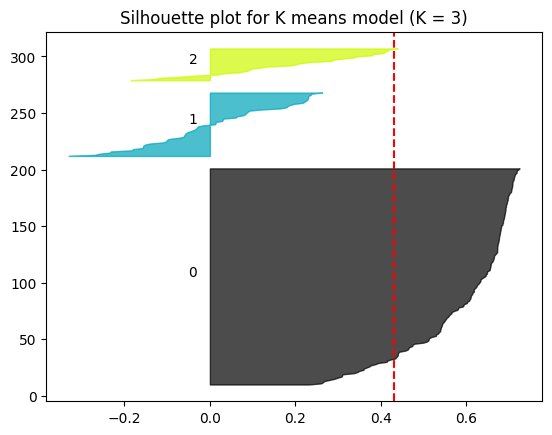

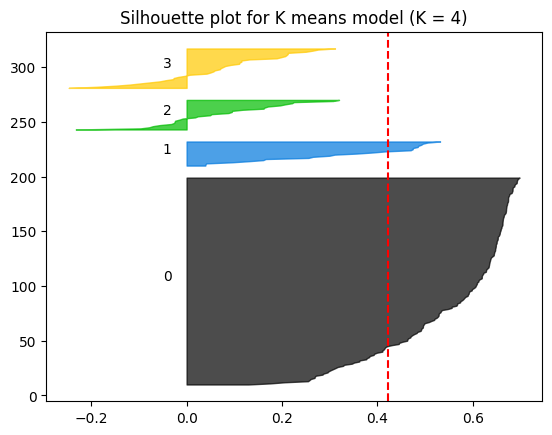

In [39]:
DataFrame({"exercise_log_id": median_times_per_stage_without_outliers.index, "label": k3_means_final_model_labels}).to_csv("data/temp/k3_means_final_model_labels.csv", index=False)
DataFrame({"exercise_log_id": median_times_per_stage_without_outliers.index, "label": k4_means_final_model_labels}).to_csv("data/temp/k4_means_final_model_labels.csv", index=False)

#k3_means_final_model_metrics = calculate_cluster_evaluation_metrics(median_times_per_stage_df, k3_means_final_model_labels)
silhouette_values = metrics.silhouette_samples(median_times_per_stage_without_outliers, k3_means_final_model_labels)
silhouette_scores = metrics.silhouette_score(median_times_per_stage_without_outliers, k3_means_final_model_labels)
fig, ax = plot_silhouette_plot(k3_means_final_model_labels, silhouette_values, silhouette_scores, 3)
plt.title(f"Silhouette plot for K means model (K = 3)")
plt.show()

#k4_means_final_model_metrics = calculate_cluster_evaluation_metrics(median_times_per_stage_df, k4_means_final_model_labels)
silhouette_values = metrics.silhouette_samples(median_times_per_stage_without_outliers, k4_means_final_model_labels)
silhouette_scores = metrics.silhouette_score(median_times_per_stage_without_outliers, k4_means_final_model_labels)
fig, ax = plot_silhouette_plot(k4_means_final_model_labels, silhouette_values, silhouette_scores, 4)
plt.title(f"Silhouette plot for K means model (K = 4)")
plt.show()

Evaluation metrics generally favour K=4, with the only metric lower for K=3 being the ASW. The silhouette plot for K=3 clearly shows some large differences in cluster 1. The K=4 model therefore seems more useful, especially with its TWCSS, point biserial value, and Hubert's C having more favourable values.

### K-Medoids

We've already standardised and removed missing values, so the first thing to do is to visualise an elbow plot. We initially also tried this with the student DataFrame but the AWS's were incredibly low (generally < 0.2).

Here, we visualise different dissimilarity measures (euclidean, manhattan, and minkowski). We have to pre-create the dissimilarity matrices to do this. **TODO: Sort out random variation in this to ensure I'm getting the best model**

In [40]:
K: int = 10
max_iter: int = 100
k_medoids_solutions: DataFrame = DataFrame(columns=["k", "Total within-cluster sum of squares", "Average silhouette width", "Dissimilarity measure"])

i: int = 0
for dissimilarity_measure in ["euclidean", "manhattan", "minkowski"]:
    # Exercise attempts dataframe
    df = metrics.pairwise_distances(median_times_per_stage_without_outliers, metric=dissimilarity_measure)
    for k in range(2, K + 1):
        k_medoids_intermediate = fastpam1(df, k, max_iter=max_iter)
        average_silhouette_score = metrics.silhouette_score(median_times_per_stage_without_outliers, k_medoids_intermediate.labels, metric=dissimilarity_measure)
        k_medoids_solutions.loc[i] = [k, k_medoids_intermediate.loss, average_silhouette_score, dissimilarity_measure]
        i += 1

px.line(
    k_medoids_solutions,
    x="k",
    y="Total within-cluster sum of squares",
    color="Dissimilarity measure",
    title="Elbow plot for k-medoids clustering"
).show()

px.line(
    k_medoids_solutions,
    x="k",
    y="Average silhouette width",
    color="Dissimilarity measure",
    title="Change in ASW for k-medoids clustering"
).show()

#### Parameter Tuning

There's clearly not much of an elbow for this measure (and very little different between the euclidean and minkowski measures). However, the TWCSS for both of these dissimilarity measures are much lower than the K-means solutions, so the k=4 solution with euclidean distance is further explored.

In [41]:
df = metrics.pairwise_distances(median_times_per_stage_without_outliers, metric="minkowski")

for init in ["random", "build"]:
    for max_iter in [1, 50, 100]:
        k_medoids = fastpam1(df, medoids=4, max_iter=max_iter, init=init, random_state=0)
        print(f"k=4: {init}, {max_iter}: {k_medoids.loss}")
    print()

k=4: random, 1: 220.4198823054077
k=4: random, 50: 206.13329868401536
k=4: random, 100: 206.13329868401536

k=4: build, 1: 206.18036775773194
k=4: build, 50: 206.18036775773194
k=4: build, 100: 206.18036775773194



In [42]:
k_medoids_final_model = fastpam1(df, medoids=4, max_iter=50, random_state=0)
k_medoids_final_model_labels = k_medoids_final_model.labels
print(f"Clusters for k=4 model: {get_size_of_clusters(k_medoids_final_model_labels)}")

Clusters for k=4 model: {1: 28, 2: 83, 3: 40, 4: 127}


#### Evaluating Internal Cluster Quality
To decide whether to take these candidate solutions forward, we work out some evaluative statistics of these clusters.

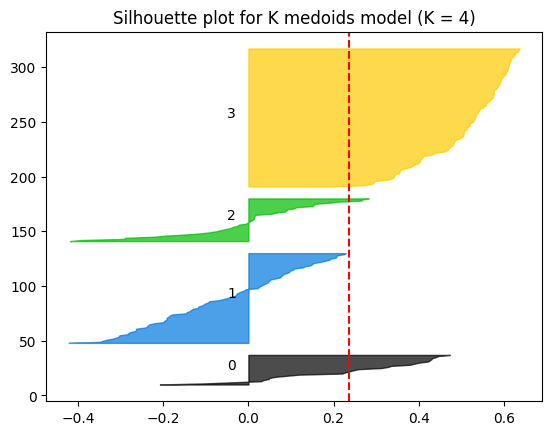

In [43]:
silhouette_values = metrics.silhouette_samples(median_times_per_stage_without_outliers, k_medoids_final_model_labels)
silhouette_scores = metrics.silhouette_score(median_times_per_stage_without_outliers, k_medoids_final_model_labels)
fig, ax = plot_silhouette_plot(k_medoids_final_model_labels, silhouette_values, silhouette_scores, 4)
plt.title(f"Silhouette plot for K medoids model (K = 4)")
plt.show()

### Agglomerative Hierarchical Clustering

Procedure:
- Try a variation of linkage criteria and dissimilarity measures.
- Visualise the dendrogram and cut at the most appropriate places (could cut at several points).

After a manual inspection the following combinations of parameters:
- Any model with single linkage
- Average linkage and city block dissimilarity
- Average linkage and minkowski dissimilarity

**Do standardised values need to be used here?**

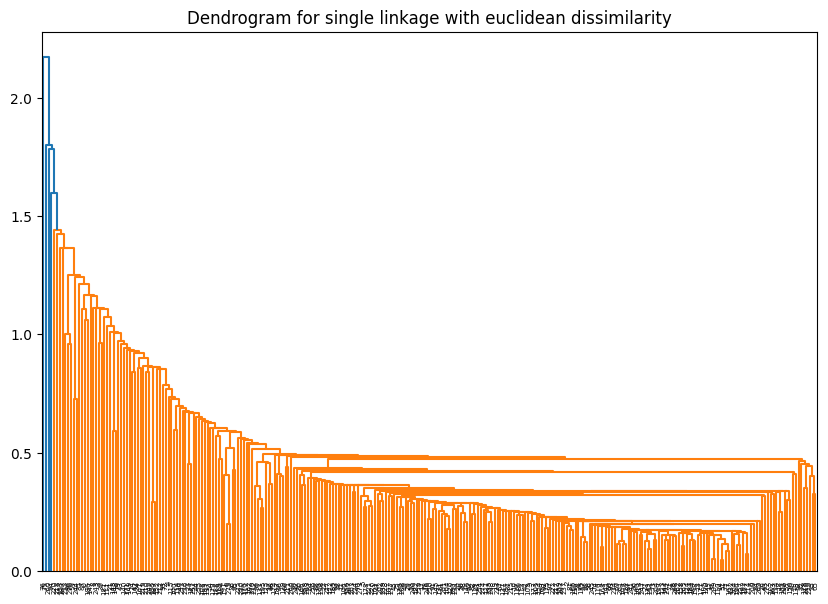

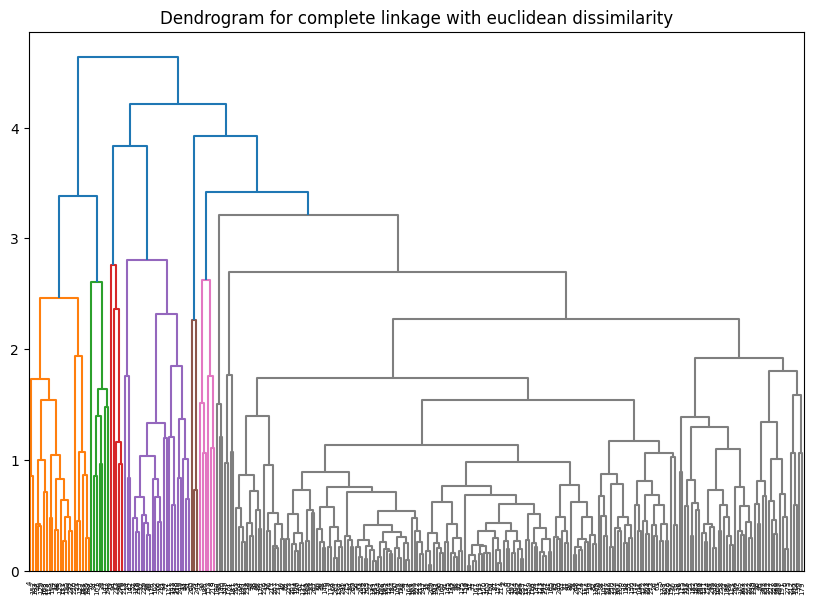

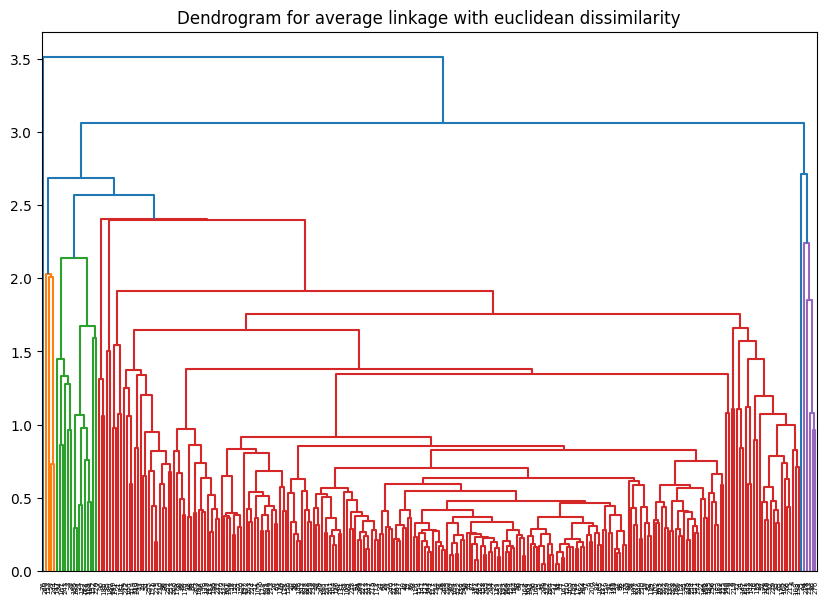

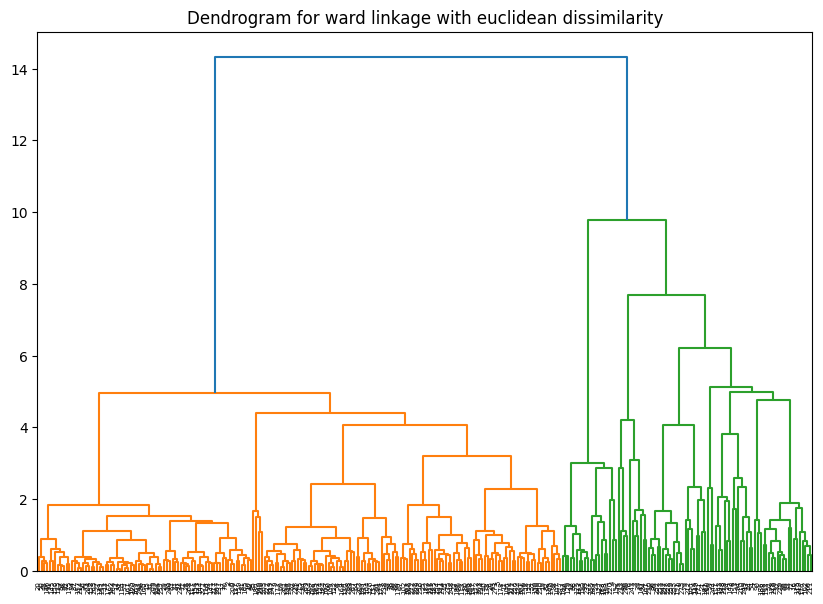

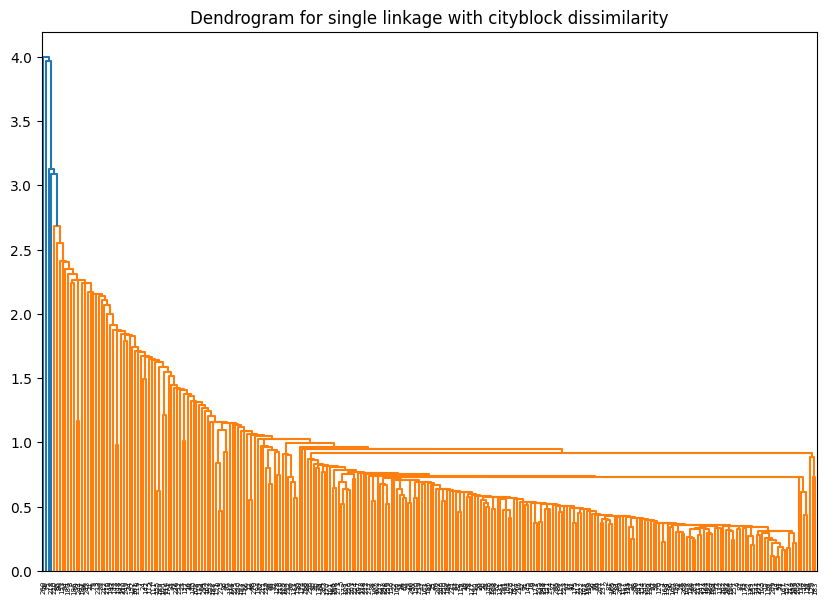

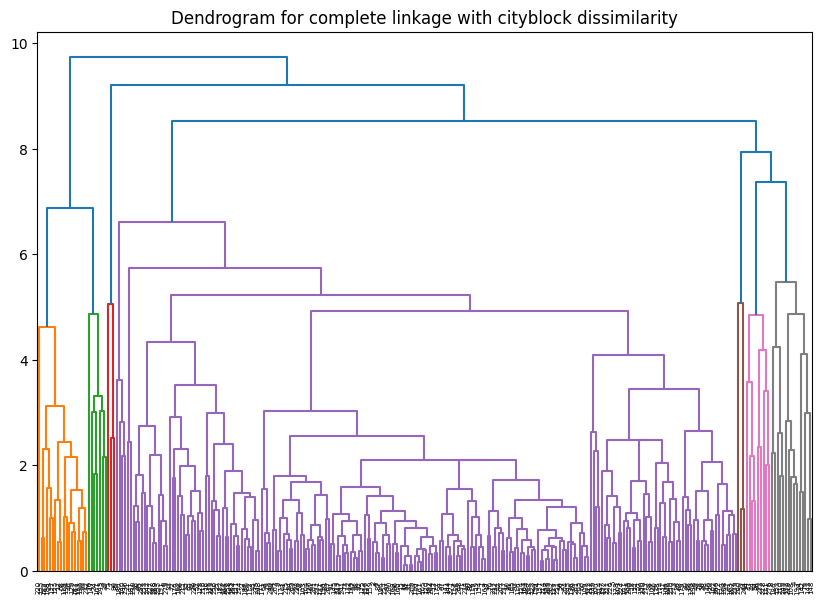

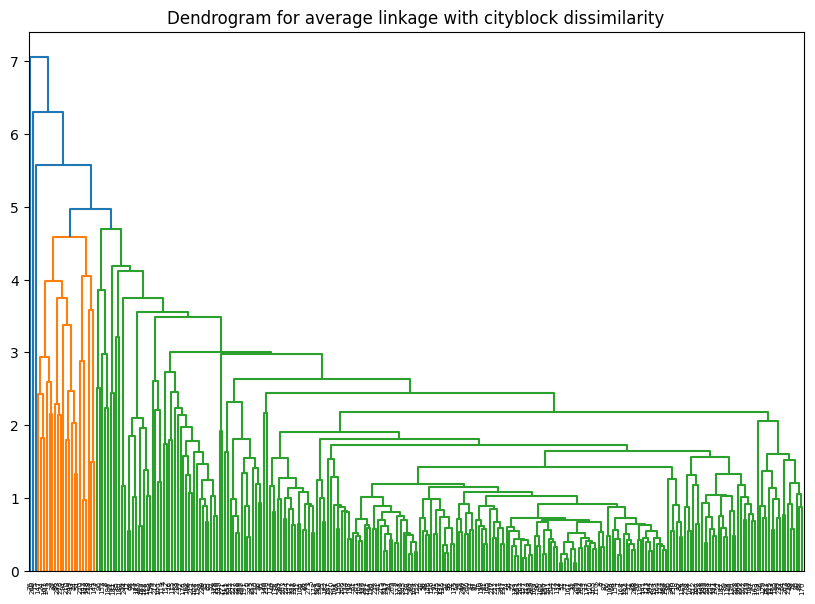

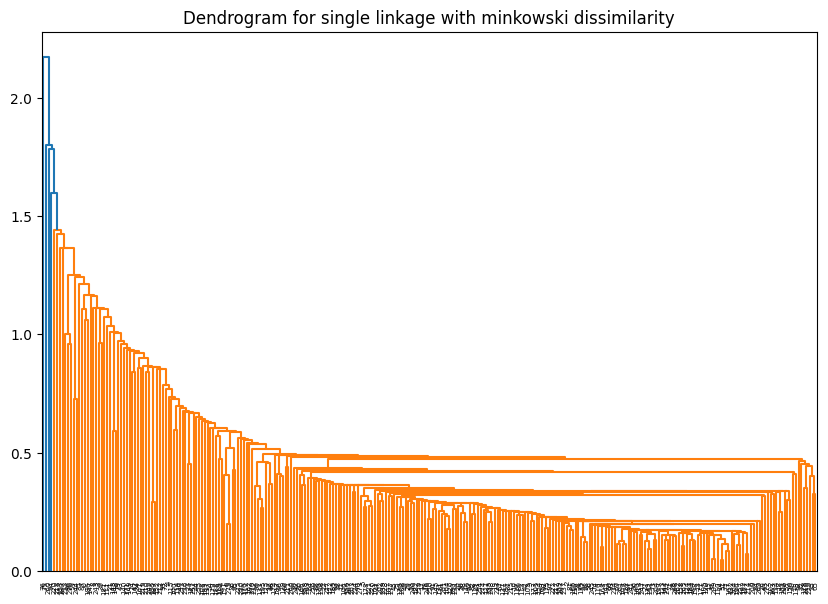

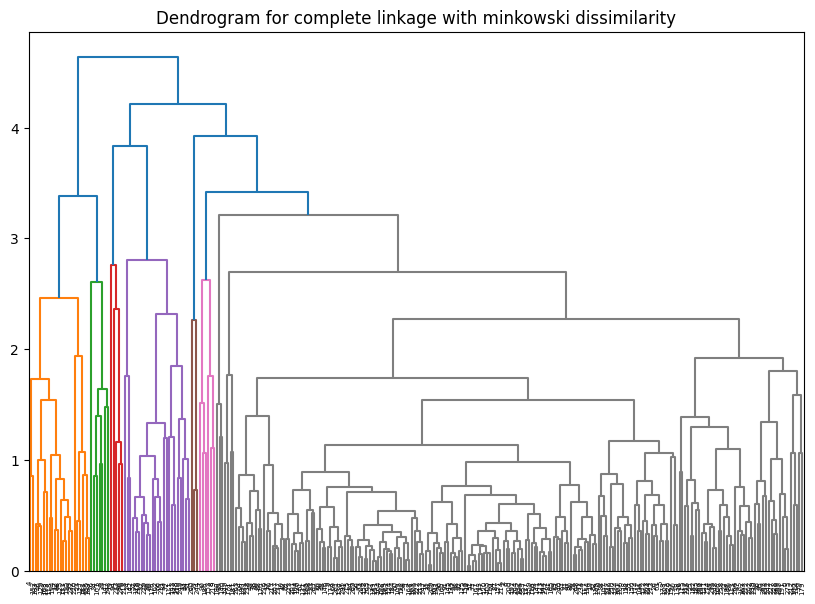

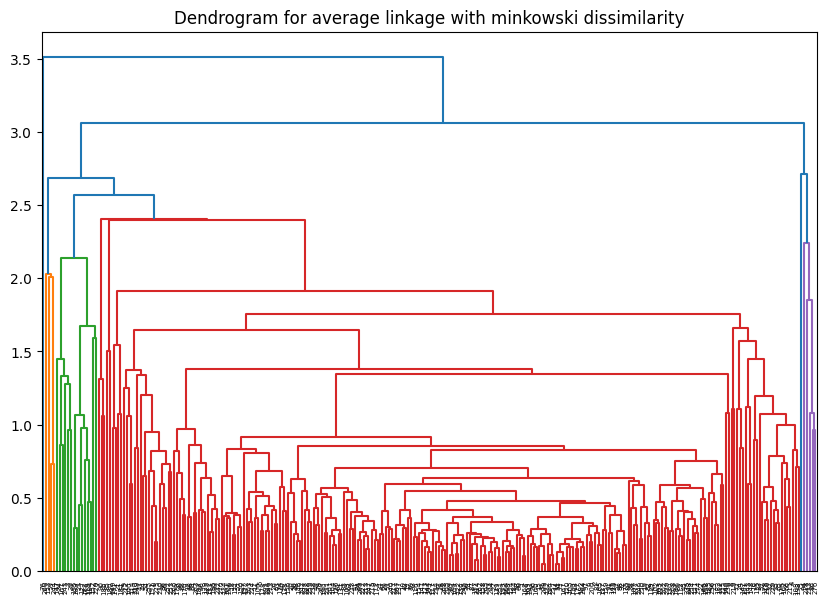

In [44]:
linkage_methods: list[str] = ["single","complete", "average", "ward"]
for dissimilarity_measure in ["euclidean", "cityblock", "minkowski"]:
    for linkage_method in linkage_methods:
        if (linkage_method == "ward" and dissimilarity_measure != "euclidean"):
            continue  # Ward only works with Euclidean distance
        plt.figure(figsize=(10, 7))
        linkage_model = linkage(median_times_per_stage_without_outliers, method=linkage_method, metric=dissimilarity_measure)
        plt.title(f"Dendrogram for {linkage_method} linkage with {dissimilarity_measure} dissimilarity")
        dendrogram(linkage_model)
        plt.show()

#### Selecting candidate solutions

Now we have plotted several dendrograms, we can remove some through visual inspection:
- All solutions where `linkage_method = "single"` produces undesirable chaining effects.
- `{linkage_method: "average", dissimilarity_measure: "euclidean"}` as this generates a huge cluster (coloured red in the dendogram) and several other very small clusters.
- `{linkage_method: "average", dissimilarity_measure: "cityblock"}` produces an undesirable chaining effect.
- `{linkage_method: "average", dissimilarity_measure: "minkowski"}` suffers from the same problem as the cluster with `{linkage_method: "average", dissimilarity_measure: "euclidean"}`.

This means we move on with the models in the `candidate_models` list below. Some of these could be cut at different points; the number of clusters that should be evaluated is indicated by the `k` variable in `candidate_models`. We generate cluster models based on each of these and evaluate them using:

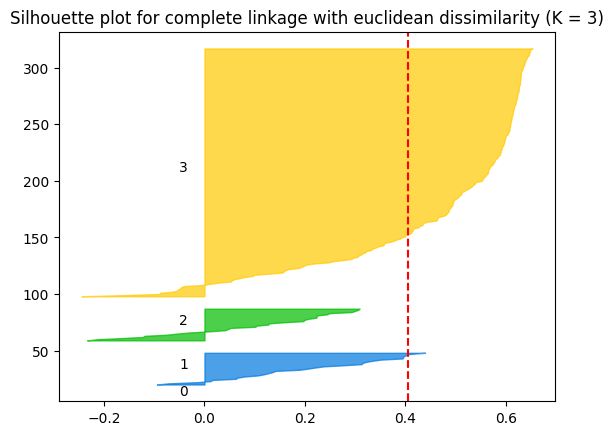

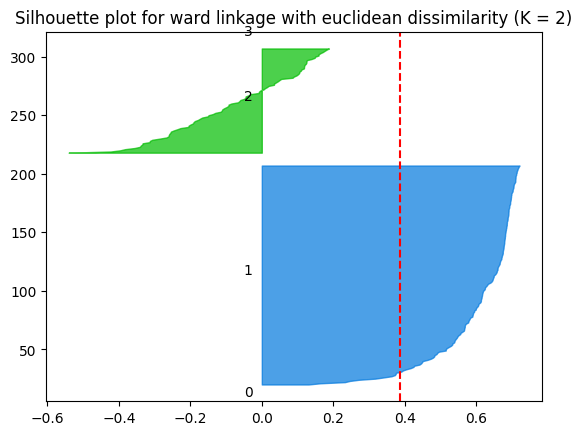

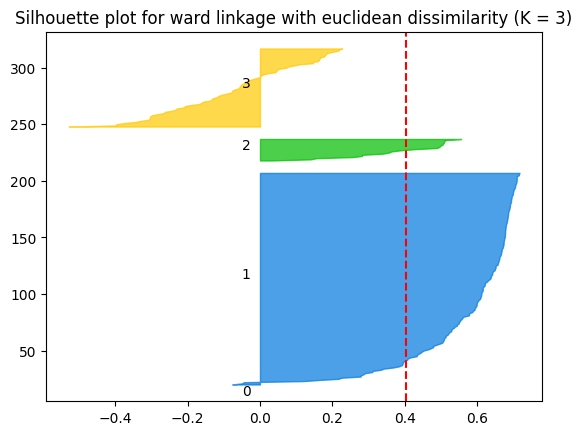

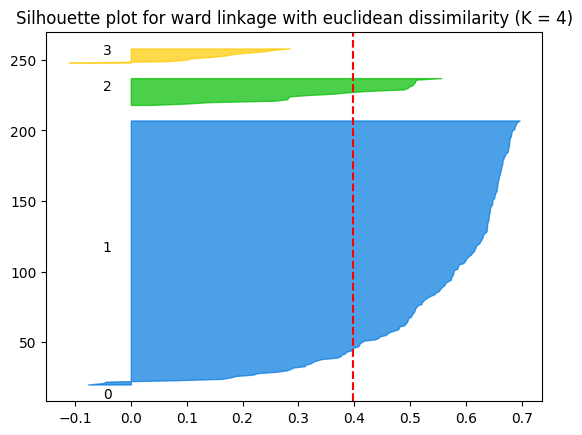

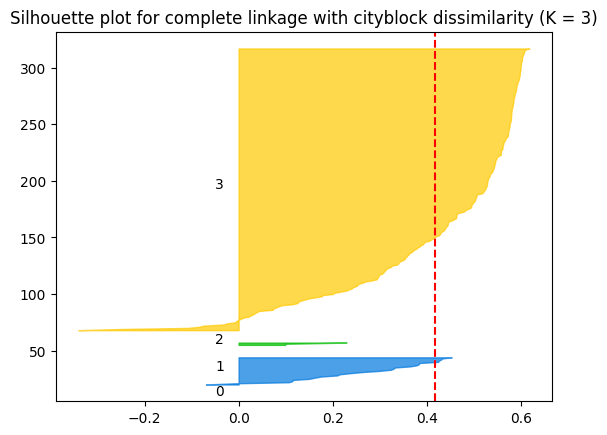

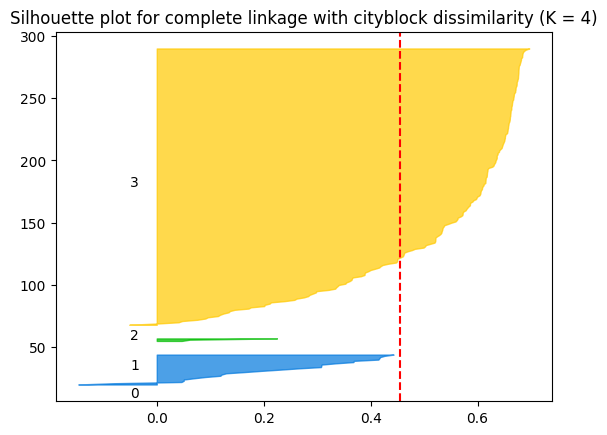

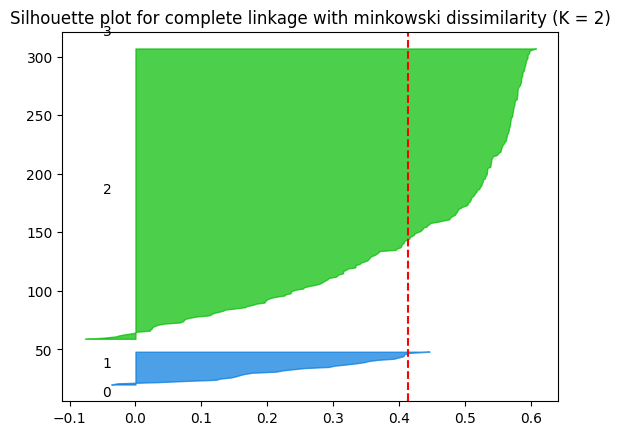

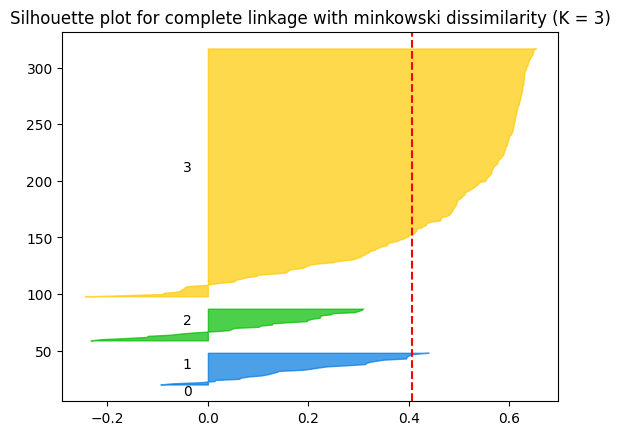

In [45]:
candidate_models: list[dict[str, str]] = [{
    "linkage_method": "complete",
    "dissimilarity_measure": "euclidean",
    "n_clusters": [3]
},
{
    "linkage_method": "ward",
    "dissimilarity_measure": "euclidean",
    "n_clusters": [2, 3, 4]
},
{
    "linkage_method": "complete",
    "dissimilarity_measure": "cityblock",
    "n_clusters": [3, 4]
},
{
    "linkage_method": "complete",
    "dissimilarity_measure": "minkowski",
    "n_clusters": [2, 3]
}]

for model in candidate_models:
    for n_clusters in model["n_clusters"]:
        linkage_model = linkage(median_times_per_stage_without_outliers, method=model["linkage_method"], metric=model["dissimilarity_measure"])
        cluster_labels = fcluster(linkage_model, n_clusters, criterion='maxclust')
        silhouette_values = metrics.silhouette_samples(median_times_per_stage_without_outliers, cluster_labels)
        silhouette_scores = metrics.silhouette_score(median_times_per_stage_without_outliers, cluster_labels)
        fig, ax = plot_silhouette_plot(cluster_labels, silhouette_values, silhouette_scores, 4)
        plt.title(f"Silhouette plot for {model['linkage_method']} linkage with {model['dissimilarity_measure']} dissimilarity (K = {n_clusters})")
        plt.show()

#### Evaluating Internal Cluster Quality
Now we've experimented with different clusters, we narrow down our clustering models and perform some final evaluation on the following AHC
- Ward linkage (K = 4)
- Complete linkage with cityblock similarity (K = 4)

We calculate the following evaluation metrics for each clustering model.
- Average Silhouette Width
- Point Biserial Correlation
- Hubert's C
In order to calculate the latter two metrics, we need to import the weighted

In [46]:
#weightedcluster = importr('WeightedCluster')

ahc_ward_model = linkage(median_times_per_stage_without_outliers, method="ward")
ahc_ward_model_labels = fcluster(ahc_ward_model, 4, criterion='maxclust')
#ahc_ward_model_labels_metrics = calculate_cluster_evaluation_metrics(median_time_per_stage_without_outliers, ahc_ward_model_labels)

ahc_complete_linkage_cityblock = linkage(median_times_per_stage_without_outliers, method="ward")
ahc_complete_linkage_cityblock_labels = fcluster(ahc_complete_linkage_cityblock, 4, criterion='maxclust')
#ahc_complete_linkage_cityblock_metrics = calculate_cluster_evaluation_metrics(median_time_per_stage_without_outliers, ahc_complete_linkage_cityblock_labels, "cityblock")

"""
for metrics in [k_means_final_model_metrics, ahc_ward_model_labels_metrics, ahc_complete_linkage_cityblock_metrics]:
    print("Evaluation metrics:")
    print(f"Point Biserial correlation coefficient: {metrics["point_biserial_correlation"]:.2f}")
    print(f"Average silhouette width: {metrics["average_silhouette_width"]:.2f}")
    print(f"Hubert's C: {metrics["huberts_c"]:.2f}\n")
"""

'\nfor metrics in [k_means_final_model_metrics, ahc_ward_model_labels_metrics, ahc_complete_linkage_cityblock_metrics]:\n    print("Evaluation metrics:")\n    print(f"Point Biserial correlation coefficient: {metrics["point_biserial_correlation"]:.2f}")\n    print(f"Average silhouette width: {metrics["average_silhouette_width"]:.2f}")\n    print(f"Hubert\'s C: {metrics["huberts_c"]:.2f}\n")\n'

In [47]:
import pandas as pd

pd.DataFrame({"exercise_log_id": median_times_per_stage_without_outliers.index, "label": ahc_ward_model_labels}).to_csv("data/temp/ahc_ward_model_labels.csv", index=False)
pd.DataFrame({"exercise_log_id": median_times_per_stage_without_outliers.index, "label": ahc_complete_linkage_cityblock_labels}).to_csv("data/temp/ahc_complete_linkage_cityblock_labels.csv", index=False)

The metrics of these two clusters are again similar, so before deciding whether any of these should be used, we perform further evaluation through comparing clusters

### Model-Based Clustering
Currently being implemented in `r_clustering.ipynb`

### Final Evaluation: Comparing Clusters
We now have a set of cluster models listed below:
- K Means model (K = 3)
- K Means model (K = 4)
- Ward linkage (K = 4)
- Complete linkage with cityblock similarity (K = 4)

We compare the cluster centroids (for the K-means models) and the median time spent on each PRIMMDebug stage (for the AHC models) to see if they are similar. This acts as a step of evaluation, as their similarity helps point to whether the clustering has consistently revealed some underlying structure.

In [48]:
exercise_logs_to_clusters_k3_means: DataFrame = DataFrame()
exercise_logs_to_clusters_k3_means.name = "K Means (K=3)"
exercise_logs_to_clusters_k3_means["exercise_log_id"] = median_times_per_stage_without_outliers.index
exercise_logs_to_clusters_k3_means["cluster"] = [i+1 for i in k3_means_final_model_labels]

k3_means_final_model_centroids = DataFrame(scaler.inverse_transform(k3_means_final_model.cluster_centers_), columns=median_times_per_stage_without_outliers.columns)
plot_median_times_per_stage_of_cluster_centroids(k3_means_final_model_centroids, model_name="K Means (K=3)")

exercise_logs_to_clusters_k4_means: DataFrame = DataFrame()
exercise_logs_to_clusters_k4_means.name = "K Means (K=4)"
exercise_logs_to_clusters_k4_means["exercise_log_id"] = median_times_per_stage_without_outliers.index
exercise_logs_to_clusters_k4_means["cluster"] = [i+1 for i in k4_means_final_model_labels]

k4_means_final_model_centroids = DataFrame(scaler.inverse_transform(k4_means_final_model.cluster_centers_), columns=median_times_per_stage_without_outliers.columns)
plot_median_times_per_stage_of_cluster_centroids(k4_means_final_model_centroids, model_name="K Means (K=4)")

exercise_logs_to_clusters_ahc_ward: DataFrame = DataFrame()
exercise_logs_to_clusters_ahc_ward["exercise_log_id"] = median_times_per_stage_without_outliers.index
exercise_logs_to_clusters_ahc_ward["cluster"] = ahc_ward_model_labels
plot_median_times_per_stage_of_clusters(exercise_logs_to_clusters_ahc_ward, EXERCISE_LOGS, "AHC with Ward")


exercise_logs_to_clusters_ahc_complete_linkage: DataFrame = DataFrame()
exercise_logs_to_clusters_ahc_complete_linkage["exercise_log_id"] = median_times_per_stage_without_outliers.index
exercise_logs_to_clusters_ahc_complete_linkage["cluster"] = ahc_complete_linkage_cityblock_labels
plot_median_times_per_stage_of_clusters(exercise_logs_to_clusters_ahc_complete_linkage, EXERCISE_LOGS, model_name="AHC Complete Linkage (Cityblock)")

exercise_logs_to_clusters_model_based: DataFrame = read_csv("data/temp/model_based_cluster_labels.csv")
exercise_logs_to_clusters_model_based.name = "Model-Based Clustering"

median_times_per_stage_model_based: DataFrame = read_csv("data/temp/model_based_cluster_means.csv", index_col=0)
median_times_per_stage_model_based = DataFrame(scaler.inverse_transform(median_times_per_stage_model_based), index=median_times_per_stage_model_based.index, columns=median_times_per_stage_model_based.columns)
plot_median_times_per_stage_of_cluster_centroids(median_times_per_stage_model_based, model_name="Model-Based Clustering")

A positive sign is that for each of the 4-cluster models, the average times for each stage is similar. This acts as further confirmation of the applicability of a clustering solution where K=4. We now move onto to selecting a final model to properly investigate.

## Investigating different cluster solutions
Now we've obtained some clustering solutions, we see how exercise attempts within each cluster correlate to:
- Success on exercise attempts (whether final program passed test harnesses)
- Median time on PRIMMDebug challenge
- Median time on each PRIMMDebug stage
- Number of stages

### K means model

### Selecting Final Cluster Solution
TODO: Justify why K-4 means was chosen (model-based didn't demonstrate to other clusters, and this had most positive cluster metrics)

In [49]:
print(f"Size of clusters: {get_size_of_clusters(k3_means_final_model_labels)}")

plot_correctness_of_clusters(exercise_logs_to_clusters_k3_means, EXERCISE_LOGS, model_name=exercise_logs_to_clusters_k3_means.name)
plot_median_times_per_stage_of_clusters(exercise_logs_to_clusters_k3_means, EXERCISE_LOGS, model_name=exercise_logs_to_clusters_k3_means.name)
plot_median_times_per_exercise_of_clusters(exercise_logs_to_clusters_k3_means, EXERCISE_LOGS, model_name=exercise_logs_to_clusters_k3_means.name)

plot_correctness_of_clusters(exercise_logs_to_clusters_k4_means, EXERCISE_LOGS, model_name=exercise_logs_to_clusters_k4_means.name)
plot_median_times_per_stage_of_clusters(exercise_logs_to_clusters_k4_means, EXERCISE_LOGS, model_name=exercise_logs_to_clusters_k4_means.name)
plot_median_times_per_exercise_of_clusters(exercise_logs_to_clusters_k4_means, EXERCISE_LOGS, model_name=exercise_logs_to_clusters_k4_means.name)

Size of clusters: {1: 192, 2: 57, 3: 29}


### Model-based model

In [50]:
exercise_logs_to_clusters_model_based: DataFrame = read_csv("data/temp/model_based_cluster_labels.csv")
exercise_logs_to_clusters_model_based.name = "Model-Based Clustering"

print(f"Size of clusters: {get_size_of_clusters(exercise_logs_to_clusters_model_based['cluster'])}")

plot_correctness_of_clusters(exercise_logs_to_clusters_model_based, EXERCISE_LOGS, model_name=exercise_logs_to_clusters_model_based.name)
plot_median_times_per_stage_of_clusters(exercise_logs_to_clusters_model_based, EXERCISE_LOGS, model_name=exercise_logs_to_clusters_model_based.name)
plot_median_times_per_exercise_of_clusters(exercise_logs_to_clusters_model_based, EXERCISE_LOGS, model_name=exercise_logs_to_clusters_model_based.name)

Size of clusters: {2: 87, 3: 85, 4: 44, 5: 62}


## Correlations
Based on the clusters being inconclusive, we wanted to confirm the relationship between the time spent on different PRIMMDebug stages (and the challenges as a whole) with success.

In [51]:

time_per_stage_success = DataFrame(scaler.inverse_transform(median_times_per_stage_with_outliers), index=median_times_per_stage_with_outliers.index, columns=median_times_per_stage_with_outliers.columns).copy()
exercise_log_id_to_log = {log.id: log for log in EXERCISE_LOGS if hasattr(log, "test_report") and log.test_report is not None}
time_per_stage_success["success"] = [
    (exercise_log_id_to_log[log_id].test_report.n_successful_tests == exercise_log_id_to_log[log_id].test_report.n_total_tests)
    if log_id in exercise_log_id_to_log else np.nan
    for log_id in time_per_stage_success.index
]
stage_success = time_per_stage_success["success"]

for stage in columns:
    stage_values = time_per_stage_success[stage]
    pointbiserialr_coefficient, p_value = pointbiserialr(stage_values, stage_success)
    print(f"Point Biserial correlation coefficient for {stage}: {pointbiserialr_coefficient:.2f}, p-value: {p_value:.4f}")
print()

#Correlation between time on challenge and correctness
time_on_challenge_success = DataFrame(columns=["time_on_challenge", "success"])
for log in EXERCISE_LOGS:
    if hasattr(log, "test_report") and log.test_report is not None:
        time_on_challenge_success.loc[log.id] = [
            ExerciseLogProcessor.get_time_on_exercise(log),
            (log.test_report.n_successful_tests == log.test_report.n_total_tests)
        ]
pointbiserialr_coefficient, p_value = pointbiserialr(time_on_challenge_success["time_on_challenge"], time_on_challenge_success["success"])
print(f"Point Biserial correlation coefficient for time on challenge and correctness: {pointbiserialr_coefficient:.2f}, p-value: {p_value:.4f}")

Point Biserial correlation coefficient for predict: -0.06, p-value: 0.2998
Point Biserial correlation coefficient for run: -0.26, p-value: 0.0000
Point Biserial correlation coefficient for spot_the_defect: 0.01, p-value: 0.7960
Point Biserial correlation coefficient for inspect_the_code: 0.02, p-value: 0.6953
Point Biserial correlation coefficient for find_the_error: -0.04, p-value: 0.4813
Point Biserial correlation coefficient for fix_the_error: -0.03, p-value: 0.5804
Point Biserial correlation coefficient for test: 0.10, p-value: 0.0909

Point Biserial correlation coefficient for time on challenge and correctness: -0.01, p-value: 0.8827


# Appendix B: Save Logs Documentation
Some extra documentation on how the logs are fetched from the Firestore database, parsed, and saved.